# XGBoost & Hyperparameter tuning


* [1. Loading and Inspecting Data](#2.-Loading-and-Inspecting-Data)
* [2. Data preprocessing](#3.-Data-preprocessing)
* [2.1 Fill NaN values](#3.1-Fill-NaN-values)
* [2.2 Encoding ordinal features](#3.2-Encoding-ordinal-features)
* [2.3 Encode nominal features](#3.3-Encode-nominal-features)
* [3. Feature Engineering](#4.-Feature-Engineering)
* [4. Normalize](#5.-Normalize)
* [5. Fit Models](#6.-Fit-Models)
* [5.1 Base line model](#6.1-Base-line-model)
* [5.2 XGBoost](#6.2-XGBoost)
    * [Parameters](#Parameters)
    * [Tuning the hyper-parameters](#Tuning-the-hyper-parameters)
    * [Best Fit](#Best-Fit)
* [6. Compare Models](#7.-Compare-Models)
* [7. Plot Results](#8.-Plot-Results)
* [8. Predic Test & Submission](#9.-Predic-Test-&-Submission)





<br>Reference:</br>
<br>https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
<br>https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
<br>https://scikit-learn.org/stable/modules/grid_search.html#multimetric-grid-search
<br>https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

# 1. Loading and Inspecting Data

In [1]:
#Importing packages
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Load dataset
train = pd.read_csv("../input/train.csv")
test  = pd.read_csv("../input/test.csv")

train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
#Dataset shape
print('Train %s\nTest %s' % (train.shape, test.shape))

Train (1460, 81)
Test (1459, 80)


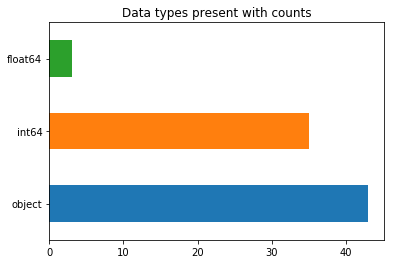

In [4]:
#Check the data types
train.dtypes.value_counts().plot(kind='barh')
plt.title('Data types present with counts')
plt.show()

In [5]:
#Describe data set
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
#Feature to predict
list(set(train.columns) - set(test.columns))

['SalePrice']

# 2. Data preprocessing

<ul>
    <li>First I'll replace the numeric missing values (NaN's) with 0 and non numeric with none.
    <li>Create Dummy variables for the categorical features.
    <li>transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal.
</ul>

## 2.1 Fill NaN values

In [7]:
#save and drop id
train_id = train["Id"]
train.drop(columns='Id',inplace=True)

test_id = test["Id"]
test.drop(columns='Id',inplace=True)

#select object columns
obj_col = train.columns[train.dtypes == 'object'].values

#select non object columns
num_col = train.columns[train.dtypes != 'object'].values
num_col_test = test.columns[test.dtypes != 'object'].values

#replace null value in obj columns with None
train[obj_col] = train[obj_col].fillna('None')
test[obj_col] = test[obj_col].fillna('None')

#replace null value in numeric columns with 0
train[num_col] = train[num_col].fillna(0)
test[num_col_test] = test[num_col_test].fillna(0)

# 3. Feature Engineering

In [8]:
#TotalBath
train['TotalBath'] = (train['FullBath'] + train['HalfBath'] + 
                         train['BsmtFullBath'] + train['BsmtHalfBath'])
test['TotalBath'] = (test['FullBath'] + test['HalfBath'] + 
                         test['BsmtFullBath'] + test['BsmtHalfBath'])

#TotalPorch
train['TotalPorch'] = (train['OpenPorchSF'] + train['3SsnPorch'] + train['EnclosedPorch'] 
                       + train['ScreenPorch'] + train['WoodDeckSF'])
test['TotalPorch'] = (test['OpenPorchSF'] + test['3SsnPorch'] + test['EnclosedPorch'] 
                       + test['ScreenPorch'] + test['WoodDeckSF'])

#Modeling happen during the sale year
train["RecentRemodel"] = (train["YearRemodAdd"] == train["YrSold"]) * 1
test["RecentRemodel"] = (test["YearRemodAdd"] == test["YrSold"]) * 1

#House sold in the year it was built
train["NewHouse"] = (train["YearBuilt"] == train["YrSold"]) * 1
test["NewHouse"] = (test["YearBuilt"] == test["YrSold"]) * 1

#HasPool
train['HasPool'] = train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
test['HasPool']  = test['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

#HasFireplaces
train['HasFirePlace'] = train['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
test['HasFirePlace'] = test['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

#Has2ndFloor
train['Has2ndFloor'] = train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
test['Has2ndFloor'] = test['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

#HasGarage
train['HasGarage'] = train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
test['HasGarage'] = test['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

#HasBsmnt
train['HasBsmnt'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
test['HasBsmnt'] = test['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

# 4. Scale

Scalling with RobustScaler function

RobustScaler transforms the feature vector by subtracting the median and then dividing by the interquartile range (75% value — 25% value). Use RobustScaler if you want to reduce the effects of outliers, relative to MinMaxScaler.

In [9]:
#Importing packages
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer,MinMaxScaler, RobustScaler

In [10]:
#Train dataset
X = train.drop(columns="SalePrice")
y = train["SalePrice"]

#Test dataset
X_test = test

# 5. Fit Models

In [11]:
#Importing packages
from sklearn.model_selection import train_test_split

In [12]:
#Split data to train dataset and validation dataset
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=0)

## 5.1 Base line model
<br> Base model to compare the accuracy of xgboost

In [13]:
#Importing packages
from catboost import Pool, CatBoostRegressor

In [14]:
X_cat = X.iloc[:,0:10]
X_cat_test = X_test.iloc[:,0:10]

X_cat.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2


In [15]:
from catboost import Pool, CatBoostRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# initialize Pool
train_pool = Pool(X_cat, 
                  y, 
                  cat_features=[1,4,5,6,7,8,9])
test_pool = Pool(X_cat_test, 
                 cat_features=[1,4,5,6,7,8,9]) 

# specify the training parameters 
model = CatBoostRegressor(iterations=20, 
                          depth=2, 
                          learning_rate=1, 
                          loss_function='RMSE')
#train the model
model.fit(train_pool)
# make the prediction using the resulting model
preds = model.predict(test_pool)

#Compute MAE
#metrics = mean_squared_error(y, preds)

print(len(y),len(preds))

#print('Metrics:', metrics )

0:	learn: 79398.0260346	total: 54ms	remaining: 1.02s
1:	learn: 70883.3878802	total: 57.5ms	remaining: 518ms
2:	learn: 69183.1512689	total: 59.1ms	remaining: 335ms
3:	learn: 67097.9574437	total: 61.5ms	remaining: 246ms
4:	learn: 66471.7867259	total: 63.9ms	remaining: 192ms
5:	learn: 66305.3949384	total: 66.3ms	remaining: 155ms
6:	learn: 66220.9027438	total: 68ms	remaining: 126ms
7:	learn: 65459.8359350	total: 69.4ms	remaining: 104ms
8:	learn: 64803.9280314	total: 71ms	remaining: 86.8ms
9:	learn: 64189.4557770	total: 72.5ms	remaining: 72.5ms
10:	learn: 63140.9144936	total: 74ms	remaining: 60.5ms
11:	learn: 62134.5587565	total: 75.4ms	remaining: 50.3ms
12:	learn: 61358.6559590	total: 76.8ms	remaining: 41.4ms
13:	learn: 61102.8657937	total: 78.3ms	remaining: 33.6ms
14:	learn: 61042.8982313	total: 79.7ms	remaining: 26.6ms
15:	learn: 61042.6039144	total: 81.3ms	remaining: 20.3ms
16:	learn: 60774.8824145	total: 83ms	remaining: 14.6ms
17:	learn: 60764.9612856	total: 84.6ms	remaining: 9.4ms
18:

## 5.2 XGBoost

In [16]:
#Importing Packages
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import Imputer

### Parameters

<b>Default parameters</b>
<br>max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, silent=None, objective='reg:squarederror', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, importance_type='gain'

*Explanation of relevant parameters for this kernel.*


* **booster:** Select the type of model to run at each iteration
    * gbtree: tree-based models
    * gblinear: linear models
* **nthread:** default to maximum number of threads available if not set
* **objective:** This defines the loss function to be minimized

**Parameters for controlling speed**

* **subsample:** Denotes the fraction of observations to be randomly samples for each tree
* **colsample_bytree:** Subsample ratio of columns when constructing each tree.
* **n_estimators:**  Number of trees to fit.

**Important parameters which control overfiting**

* **learning_rate:** Makes the model more robust by shrinking the weights on each step
* **max_depth:** The maximum depth of a tree.
* **min_child_weight:** Defines the minimum sum of weights of all observations required in a child.

### Tuning the hyper-parameters

**GridSearchCV params:**
* **estimator:** estimator object
* **param_grid :** dict or list of dictionaries
* **scoring:** A single string or a callable to evaluate the predictions on the test set. If None, the estimator’s score method is used.
    * https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
* **n_jobs:** Number of jobs to run in parallel. None means. -1 means using all processors.
* **cv:** cross-validation, None, to use the default 3-fold cross validation. Integer, to specify the number of folds in a (Stratified)KFold.

In [17]:
#XGBoost hyper-parameter tuning
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [18]:
#Run only in the first run of the kernel.
#hyperParameterTuning(X_train, y_train)

### Best Params
{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 10,
 'min_child_weight': 5,
 'n_estimators': 500,
 'subsample': 0.5}

### Best Fit

In [19]:
xgb_model = XGBRegressor(
        objective = 'reg:squarederror',
        colsample_bytree = 0.7,
        learning_rate = 0.01,
        max_depth = 10,
        min_child_weight = 5,
        subsample = 0.5,
        n_estimators=500)

%time xgb_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_val, y_val)], verbose=False)

y_pred_xgb = xgb_model.predict(X_val)

mae_xgb = mean_absolute_error(y_val, y_pred_xgb)

print("MAE: ", mae_xgb)

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, Heating, HeatingQC, CentralAir, Electrical, KitchenQual, Functional, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, PavedDrive, PoolQC, Fence, MiscFeature, SaleType, SaleCondition

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, Heating, HeatingQC, CentralAir, Electrical, KitchenQual, Functional, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, PavedDrive, PoolQC, Fence, MiscFeature, SaleType, SaleCondition

# 6. Compare Models

In [20]:
plt.bar(['XGB', 'Baseline'], [mae_xgb, mae_baseline])
plt.ylabel('MAE')
plt.title('Compare Models')
plt.show()

NameError: name 'mae_xgb' is not defined

The XGBoost model has the smallest error.

# 7. Plot Results

In [21]:
#Importing Packages
from sklearn.decomposition import PCA

In [22]:
#reduction of dimensionality to plot
df = X_val

#Applying PCA
pca = PCA(n_components=1,whiten=True).fit(df)
dfPCA = pca.transform(df)

#Join Y val and predict
dfPCA = pd.DataFrame(dfPCA, columns = ['X'])
dfPCA['y_val'] = y.reset_index(drop=True)
dfPCA['y_pred'] = y_pred_xgb

ValueError: could not convert string to float: 'RL'

NameError: name 'dfPCA' is not defined

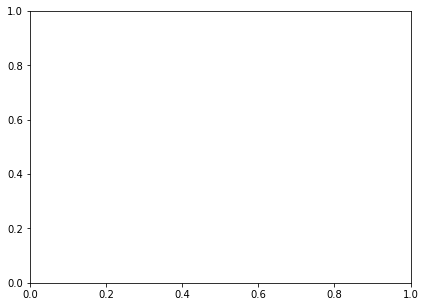

In [23]:
# Plot outputs

plt.figure(figsize=(15, 5)) #Chart size

#Chart Real and Predict
plt.subplot(1, 2, 1)
plt.scatter(dfPCA.X, dfPCA.y_val,  color='blue', label='Real', alpha=0.5)
plt.scatter(dfPCA.X, dfPCA.y_pred,  color='red', label='Predict', alpha=0.5)
plt.title("Real vs Predict")
plt.xlabel("Feature")
plt.ylabel("SalePrice")
plt.legend(loc='best')
plt.xticks(())
plt.yticks(())

#ChartReal vs Predict
plt.subplot(1, 2, 2)
plt.scatter(dfPCA.y_val, dfPCA.y_pred,  color='blue')
plt.title("Real vs Predict")
plt.xlabel("Real")
plt.ylabel("Predict")
plt.xticks(())
plt.yticks(())

plt.show()

# 8. Predic Test & Submission

In [24]:
# Use the model to make predictions
y_pred_test = xgb_model.predict(X_test)

submission = pd.DataFrame({'Id':test_id,'SalePrice':y_pred_test})

# Save results
submission.to_csv("submission.csv",index=False)

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, Heating, HeatingQC, CentralAir, Electrical, KitchenQual, Functional, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, PavedDrive, PoolQC, Fence, MiscFeature, SaleType, SaleCondition